In [3]:
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import rustworkx as rx
import rustworkx.visualization as rxv
import matplotlib.pyplot as plt
from bispy import compute_maximum_bisimulation
from tqdm import tqdm
from time import perf_counter
from itertools import product
from typing import Dict, Tuple, Any, List

In [38]:

def generate_binary_sparse_matrix(rows, cols, density=0.1):
    """
    Generate a binary sparse matrix.

    Parameters:
    rows (int): Number of rows in the matrix.
    cols (int): Number of columns in the matrix.
    density (float): Fraction of elements that are non-zero. Should be between 0 and 1.

    Returns:
    dict: A dictionary representing the binary sparse matrix.
    """
    if not (0 <= density <= 1):
        raise ValueError("Density must be between 0 and 1")
    rng = np.random.default_rng()

    num_nonzero = int(rows * cols * density)

    row = rng.integers(0, rows - 1, num_nonzero)
    column = rng.integers(0, rows - 1, num_nonzero)

    return (row, column)


def _bisimulation_from_matrix(coordinates, coo_matrix):
    """
    Computes the bisimulation from the given adjacency matrix.
    """
    t = perf_counter()
    nodes = set(coordinates[0]).union(set(coordinates[1]))
    graph = rx.PyDiGraph()
    graph.add_nodes_from(list(nodes))
    graph.add_edges_from_no_data([arrow for arrow in set(zip(coordinates[1], coordinates[0]))])

    graph_1 = rx.PyDiGraph.from_adjacency_matrix(
        coo_matrix.toarray().astype(np.float64)
    )
    graph_1.remove_nodes_from(rx.isolates(graph_1))

    print(rx.digraph_is_isomorphic(graph, graph_1))
    t = perf_counter() 
    bisim = rx.digraph_maximum_bisimulation(graph)
    print("bisimulation constructed", perf_counter()-t)
    t = perf_counter()
    bisim = rx.digraph_maximum_bisimulation(graph_1)

    print("bisimulation coo", perf_counter()-t)
    return bisim

_generate_sparse_adjacency_matrix = lambda nodes, sparsity: generate_binary_sparse_matrix(nodes, nodes, 1-sparsity)

def _run_experiment(nodes, sparsity):
    """
    Runs the experiment for the given parameters.
    """

    adjacency_matrix = _generate_sparse_adjacency_matrix(nodes, sparsity)
    num_nonzero = int(nodes**2 * 1-sparsity)

    mat = coo_matrix(
        (np.ones(len(adjacency_matrix[0])), (adjacency_matrix[0],adjacency_matrix[1])), shape=(nodes, nodes), dtype=np.int8
    )

    bisimulation = _bisimulation_from_matrix(adjacency_matrix, mat)
    return len(bisimulation)

In [4]:
def convert_rustworkx_to_networkx(graph):
    """Convert a rustworkx PyGraph or PyDiGraph to a networkx graph."""
    edge_list = [(
        graph[x[0]], graph[x[1]],
        {'weight': x[2]}) for x in graph.weighted_edge_list()]

    if isinstance(graph, rx.PyGraph):
        if graph.multigraph:
            return nx.MultiGraph(edge_list)
        else:
            return nx.Graph(edge_list)
    else:
        if graph.multigraph:
            return nx.MultiDiGraph(edge_list)
        else:
            return nx.DiGraph(edge_list)

def generate_binary_sparse_matrix(rows, cols, density=0.1):
    """
    Generate a binary sparse matrix.

    Parameters:
    rows (int): Number of rows in the matrix.
    cols (int): Number of columns in the matrix.
    density (float): Fraction of elements that are non-zero. Should be between 0 and 1.

    Returns:
    dict: A dictionary representing the binary sparse matrix.
    """
    if not (0 <= density <= 1):
        raise ValueError("Density must be between 0 and 1")
    rng = np.random.default_rng()

    num_nonzero = int(rows * cols * density)

    row = rng.integers(0, rows - 1, num_nonzero)
    column = rng.integers(0, rows - 1, num_nonzero)

    return coo_matrix(
        (np.ones(num_nonzero), (row, column)), shape=(rows, cols), dtype=np.int8
    )


def _generate_sparse_adjacency_matrix(nodes, sparsity):
    """
    Generates a sparse adjacency matrix with the given number of nodes and sparsity.
    """
    return generate_binary_sparse_matrix(nodes, nodes, density=1 - sparsity)


def merge_isolates(graph: rx.PyDiGraph):
    isolates = rx.isolates(graph)
    for isolate in isolates[1:]:
        graph.merge_nodes(isolate, isolates[0])


def _bisimulation_from_matrix(adjacency_matrix):
    """
    Computes the bisimulation from the given adjacency matrix.
    """
    graph_1 = rx.PyDiGraph.from_adjacency_matrix(
        adjacency_matrix.toarray().astype(np.float64)
    )
    graph_1.remove_nodes_from(rx.isolates(graph_1))
    graph_1_nx = convert_rustworkx_to_networkx(graph_1)

    return rx.digraph_maximum_bisimulation(graph_1), compute_maximum_bisimulation(graph_1_nx)


def _run_experiment(nodes, sparsity):
    """
    Runs the experiment for the given parameters.
    """

    adjacency_matrix = _generate_sparse_adjacency_matrix(nodes, sparsity)
    bisimulation_0, bisimulation_1 = _bisimulation_from_matrix(adjacency_matrix)
    # for element in bisimulation_0:
    #     assert all([any([el in sol for sol in solution]) for el in element])
    try:
        assert len(bisimulation_0)==len(bisimulation_1)
        print("succ")
    except:
        print(bisimulation_0)
        print(bisimulation_1)
        print(adjacency_matrix)
        print(nodes)
        print(sparsity)
        raise ValueError("Bisimulations are not the same")


In [5]:
from collections import defaultdict
import concurrent.futures
import threading
import multiprocessing
from analysis_functions import execute_experiment

nodes = [100 + n for n in range(0, 1000, 10)]
sparsity = [1 - 2**(-n) for n in range(3, 10)]
sample_rate = {n: n**2//3000 for n in nodes}
experiment_results = defaultdict(list)

for node_count, sp in zip(nodes, sparsity):
    print(f"Running experiment for {node_count} nodes and sparsity {sp} with sample rate {sample_rate[node_count]}")
    experiment_results[(node_count, sp)] = [
        _run_experiment(node_count, sp) for _ in tqdm(range(sample_rate[node_count]), mininterval=0.1)
    ]
  
# with concurrent.futures.ProcessPoolExecutor(max_workers=15) as executor:
#     futures = []
#     for node_count, sp in tqdm(zip(nodes, sparsity)):
#         future = executor.submit(execute_experiment, node_count, sp, sample_rate)
#         futures.append(future)
    
#     # Wait for all futures to complete
#     def wait_for(futures):
#         index = 0 
#         for future in concurrent.futures.as_completed(futures):
#             yield index, future
#             index += 1

#     for future in tqdm(wait_for(futures), total=len(futures)):
#         res = future[1].result()
#         experiment_results[list(res.keys())[0]].extend(list(res.values())[0])


Running experiment for 10 nodes and sparsity 0.875 with sample rate 0


0it [00:00, ?it/s]


Running experiment for 20 nodes and sparsity 0.9375 with sample rate 0


0it [00:00, ?it/s]


Running experiment for 30 nodes and sparsity 0.96875 with sample rate 0


0it [00:00, ?it/s]


Running experiment for 40 nodes and sparsity 0.984375 with sample rate 0


0it [00:00, ?it/s]


Running experiment for 50 nodes and sparsity 0.9921875 with sample rate 0


0it [00:00, ?it/s]


Running experiment for 60 nodes and sparsity 0.99609375 with sample rate 1


RelationalCoarsestPartition[NodeList[7, 10, 11, 17, 23, 39, 42, 56], NodeList[8, 13, 58], NodeList[19, 40, 45, 6, 31, 47, 34, 43, 20], NodeList[32, 2]]
[(13, 8, 58), (23, 10, 7, 56, 42, 11, 17, 39), (6, 19, 20, 43, 31, 34, 40, 45, 47), (2,), (32,)]
  (45, 17)	1
  (40, 11)	1
  (32, 2)	1
  (13, 19)	1
  (19, 10)	1
  (34, 42)	1
  (8, 34)	1
  (47, 39)	1
  (2, 13)	1
  (43, 7)	1
  (6, 23)	1
  (31, 56)	1
  (20, 7)	1
  (58, 20)	1
60
0.99609375


ValueError: Bisimulations are not the same

In [101]:
bisim = [(13, 8, 58), (23, 10, 7, 56, 42, 11, 17, 39), (6, 19, 20, 43, 31, 34, 40, 45, 47), (2,), (32,)]
cat_dict = {
    13: 0,
    8: 0,
    58: 0,
    23: 1,
    10: 1,
    7: 1,
    56: 1,
    42: 1,
    11: 1,
    17: 1,
    39: 1,
    6: 2,
    19: 2,
    20: 2,
    43: 2,
    31: 2,
    34: 2,
    40: 2,
    45: 2,
    47: 2,
    2: 3,
    32: 4,
}
edges = {
    45: 17,
    40: 11,	
    32: 2,	
    13: 19,	
    19: 10,
    34: 42,	
    8: 34,	
    47: 39,	
    2: 13,	
    43: 7,	
    6: 23,	
    31: 56,
    20: 7,	
    58: 20,
}
flattened_bisim = sorted([element for cluster in bisim for element in cluster])
mapping = {val: i for i, val in enumerate(flattened_bisim)}


def generate_quotient_graph(bisim, edges, cat_dict):
    graph = nx.DiGraph()
    graph.add_nodes_from(range(len(bisim)))
    
    for cluster in bisim:
        for element in cluster:
            graph.add_edge(cat_dict[element], 0)
    
    return graph

graph = generate_quotient_graph(bisim, edges, cat_dict)
print(compute_maximum_bisimulation(graph))
graph_1 = nx.DiGraph()
rx_graph_1 = rx.PyDiGraph()
rx_graph_1.add_nodes_from(range(len(flattened_bisim)))
k = []
for key, value in edges.items():
    graph_1.add_edge(mapping[key], mapping[value])
    k.append((mapping[key], mapping[value]))

unique_tuples = []

for tup in k:
    if tup not in unique_tuples:
        unique_tuples.append(tup)

rx_graph_1.add_edges_from_no_data(unique_tuples)


print(compute_maximum_bisimulation(graph_1))
print([list(x) for x in rx.digraph_maximum_bisimulation(rx_graph_1)])

for block in bisim:
    rx_graph_1.contract_nodes([mapping[element] for element in block], block[0])
        
nx_graph = convert_rustworkx_to_networkx(rx_graph_1)
print(rx_graph_1.node_indices())
print(rx_graph_1.edge_list())
print(rx.digraph_maximum_bisimulation(rx_graph_1))
print(compute_maximum_bisimulation(nx_graph)) 


rx_graph_2 = rx.PyDiGraph()
rx_graph_2.add_nodes_from(range(5))
rx_graph_2.add_edges_from_no_data([(1, 3),(1, 3),(1, 3), (0, 2),(4, 1), (2, 4)])

print(rx.digraph_maximum_bisimulation(rx_graph_2))



[(0, 1, 2, 3, 4)]
[(6, 3, 21), (7, 5, 4, 16, 14, 2, 10, 20), (18, 15, 8, 13, 19, 17, 9, 1, 11), (0,), (12,)]
[[2, 4, 5, 7, 10, 14, 16, 20], [3, 6, 21], [9, 17, 1, 8, 15, 19, 11, 13, 18], [12, 0]]
NodeIndices[0, 14, 19, 21, 22]
EdgeList[(14, 21), (14, 21), (0, 19), (14, 21), (22, 14), (14, 21), (14, 21), (14, 21), (14, 21), (14, 21), (22, 14), (14, 21), (22, 14), (19, 22)]
RelationalCoarsestPartition[NodeList[21], NodeList[22], NodeList[14, 14, 14, 14, 14, 14, 14, 14, 14], NodeList[19, 0]]
[(32,), (23,), (6,), (13,), (2,)]
soo
RelationalCoarsestPartition[NodeList[3], NodeList[4], NodeList[1, 1, 1], NodeList[0, 2]]


In [11]:
# Save experiment results to a file
import pickle

with open('Experiment_results.pickle', 'wb') as file:
    pickle.dump(experiment_results, file)

# Test if the file is correct
with open('Experiment_results.pickle', 'rb') as file:
    loaded_results = pickle.load(file)

# Compare the loaded results with the original experiment results
if loaded_results == experiment_results:
    print("The file is correct.")
else:
    print("The file is incorrect.")


The file is correct.


In [8]:
loaded_results

defaultdict(list,
            {(1030, 0.984375): [2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
              2,
            

In [22]:
for results, sp in zip(experiment_results.values(), sample_rate):
    print(len(results), sp)
    assert len(results) == sp
print(sample_rate)

100 33333


AssertionError: 

In [39]:
import cProfile

# Profile the experiment function
profiler = cProfile.Profile()
profiler.enable()
_run_experiment(1000, 0.8)
profiler.disable()

# Print the profiling results
profiler.print_stats(sort='time')

Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "/var/folders/f8/gyd0q7m15jbg_r5chc34ntdm0000gn/T/ipykernel_37923/2965003237.py", line 5, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


False
bisimulation constructed 0.01195075000578072
bisimulation coo 0.007847082990338095
         316 function calls in 0.542 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.263    0.263    0.263    0.263 {digraph_is_isomorphic}
        1    0.105    0.105    0.105    0.105 {method 'add_edges_from_no_data' of 'rustworkx.PyDiGraph' objects}
        1    0.071    0.071    0.531    0.531 1216692289.py:25(_bisimulation_from_matrix)
        1    0.044    0.044    0.044    0.044 {built-in method from_adjacency_matrix}
        2    0.020    0.010    0.020    0.010 {digraph_maximum_bisimulation}
        1    0.012    0.012    0.012    0.012 1216692289.py:33(<listcomp>)
        1    0.011    0.011    0.011    0.011 {digraph_isolates}
        1    0.008    0.008    0.541    0.541 1216692289.py:52(_run_experiment)
        1    0.004    0.004    0.004    0.004 {method 'add_nodes_from' of 'rustworkx.PyDiGraph' objects}
  

In [20]:
19999999-18126456

1873543

In [3]:
import pickle

with open('tetete.pickle', 'rb') as file:
    experiment_results = pickle.load(file)

In [4]:
import numpy as np
new_results = {key: np.mean(val) for key, val in experiment_results.items()}

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.DataFrame(new_results.items(), columns=['Nodes', 'mean_bisim_reg'])
df["max_nodes"] = df["Nodes"].map(lambda x:x[0])
df["sparsity"] = df["Nodes"].map(lambda x:x[1])


df_pivot = df.pivot(index='max_nodes', columns='sparsity', values='mean_bisim_reg')


In [8]:
df_pivot[df_pivot[0.995] == max(df_pivot[0.995])]

sparsity,0.995,0.996,0.997,0.998
max_nodes,,,,
1300,249.362,240.373,167.541,93.973


In [6]:
print(8200*8200*(1-0.999))
print(8700**2*(1-0.9991))


67240.00000000006
68121.0000000009


0.996
0.997
0.998
0.995


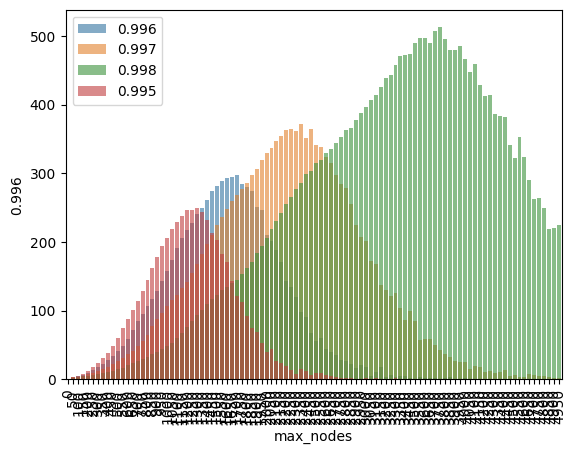

In [7]:
import scipy.stats as stats


for sparsity in df.sparsity.unique():
# for sparsity in df["sparsity"]:
    print(sparsity)
    sns.barplot(df_pivot, x="max_nodes", y=sparsity, alpha=0.6, label=sparsity)


plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()



In [265]:
1100**2*(1-0.995)

6050.0000000000055

0.996
79.95510101010102 99.51123593505976
0.997
133.34464 125.58675585247994
0.998
249.51034000000004 168.86105944090366
0.995
52.73812 78.89785274052521


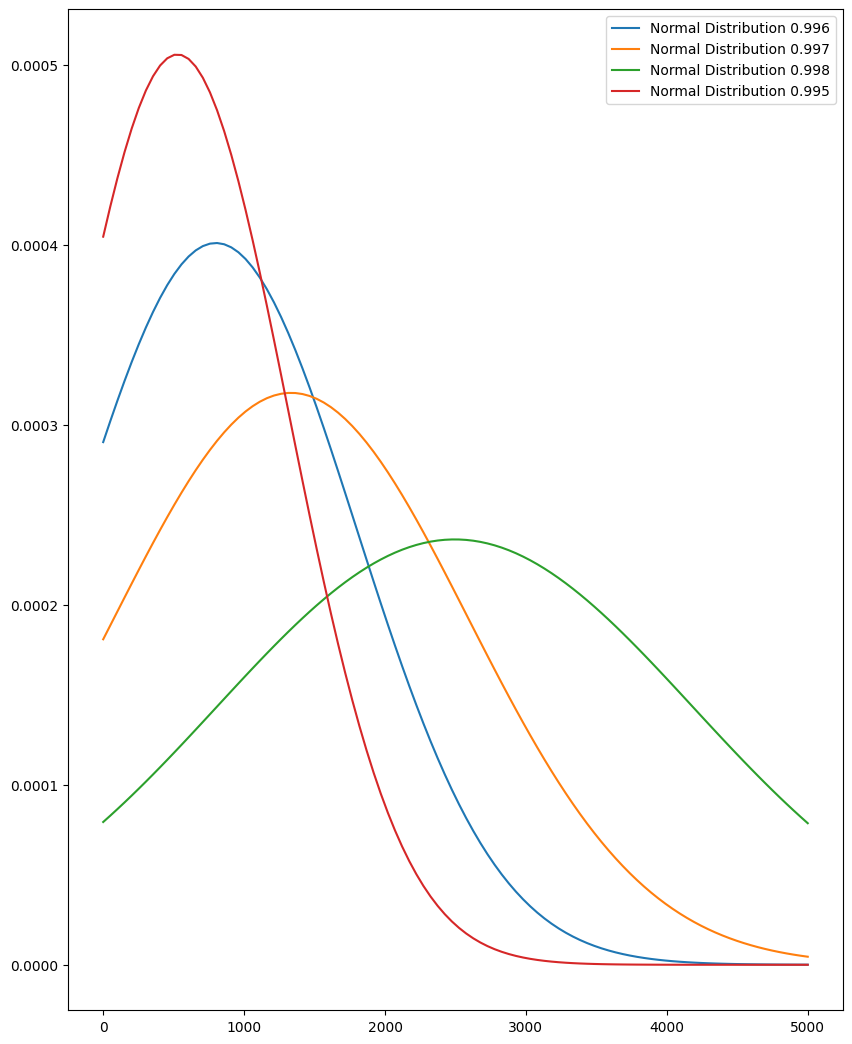

In [256]:
for sparsity in df.sparsity.unique():
    print(sparsity)

    # Fit a normal distribution to the data
    mu, sigma = stats.norm.fit(df_pivot[sparsity].dropna())
    print(mu, sigma)
    x = np.linspace(0, 5000, 100)
    y = stats.norm.pdf(x, mu*10, sigma*10)

    # Plot the normal distribution
    plt.plot(x, y, label=f'Normal Distribution {sparsity}')

plt.legend()
plt.show()

    

In [209]:
trend

[(1700, 295.947)]

In [88]:
sns.heatmap(
    fdf.pivot_table(index="sparsity", values="Mean Bisimulation Size", columns="max_nodes"),
    cmap="coolwarm",
)

ValueError: zero-size array to reduction operation fmin which has no identity

In [32]:
print(len(sparsity), len(nodes))

97 100


In [12]:
import pickle

with open('/Users/sanderhergarten/Documents/programming/Graph-Representation-Learning/experiment_results_1710425971.1718025.pickle', 'rb') as file:
    mat = pickle.load(file)

In [13]:
mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
row_sums = mat.sum(axis=1)
new_matrix = mat / row_sums[:, np.newaxis]

/var/folders/f8/gyd0q7m15jbg_r5chc34ntdm0000gn/T/ipykernel_8013/3059053132.py:2: RuntimeWarning: invalid value encountered in divide
  new_matrix = mat / row_sums[:, np.newaxis]


/opt/homebrew/Caskroom/miniconda/base/envs/graph-representation-learning/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/homebrew/Caskroom/miniconda/base/envs/graph-representation-learning/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


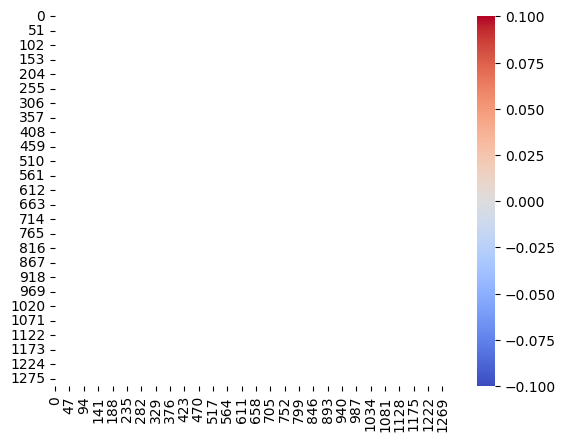

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(new_matrix, cmap='coolwarm')
plt.show()
